#Train a simple convnet on the MNIST dataset and evaluate the BALD acquisition function

Example based on Yarin Gal's code https://github.com/yaringal/acquisition_example

The acquisition function could then be used for active learning with the images the model is most confused about (highest acquisition function value).
See [Deep Bayesian Active Learning with Image Data](https://arxiv.org/abs/1703.02910).
This code extends on [the Keras CNN example](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py).

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


In [3]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# Train a simple convnet with dropout on MNIST:

In [4]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [6]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          #epochs=epochs,
          epochs = 2,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 199s 3ms/step - loss: 0.2699 - acc: 0.9157 - val_loss: 0.0729 - val_acc: 0.9767
Epoch 2/2
60000/60000 [==============================] - 186s 3ms/step - loss: 0.0897 - acc: 0.9731 - val_loss: 0.0409 - val_acc: 0.9865
Test loss: 0.0408967200012
Test accuracy: 0.9865


# Generate MC samples using keras: 
(we're doing this for the entire test set at once, which requires quite a bit of memory; might be smarter to do this in smaller chunks)

In [7]:
import numpy as np
nb_MC_samples = 20
MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

learning_phase = True  # use dropout at test time


In [41]:
aaa = MC_output([x_test[1:3,:,:,:], learning_phase])
print(aaa)
bbb = np.asarray(aaa)
print(bbb)
bbb.sum()

[array([[  4.09951113e-04,   7.86353155e-07,   9.99582112e-01,
          6.89090211e-06,   7.38141666e-12,   1.93749586e-10,
          1.10419577e-07,   6.60801067e-11,   1.97292792e-07,
          1.41636175e-10],
       [  1.28658360e-06,   9.99820888e-01,   3.57115678e-05,
          1.42926325e-07,   8.98811631e-05,   4.09960057e-06,
          3.25629226e-05,   1.31307695e-06,   1.39974736e-05,
          1.69999893e-07]], dtype=float32)]
[[[  4.09951113e-04   7.86353155e-07   9.99582112e-01   6.89090211e-06
     7.38141666e-12   1.93749586e-10   1.10419577e-07   6.60801067e-11
     1.97292792e-07   1.41636175e-10]
  [  1.28658360e-06   9.99820888e-01   3.57115678e-05   1.42926325e-07
     8.98811631e-05   4.09960057e-06   3.25629226e-05   1.31307695e-06
     1.39974736e-05   1.69999893e-07]]]


2.0

In [43]:
x_test[1:2,:,:,:].shape

(1, 28, 28, 1)

In [8]:
MC_samples = [MC_output([x_test, learning_phase])[0] for _ in xrange(nb_MC_samples)]
MC_samples = np.array(MC_samples)  # [#samples x batch size x #classes]

# Approximate the BALD acquisition function:

In [9]:
expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
expected_p = np.mean(MC_samples, axis=0)
entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
BALD_acq = entropy_expected_p - expected_entropy
print('BALD_acq on first 10 points', BALD_acq[:10])

BALD_acq on first 10 points [  1.55552290e-04   3.85571010e-02   2.19340809e-03   8.30304343e-04
   3.21959984e-03   4.09150124e-03   4.50858921e-02   4.45342660e-02
   2.36577392e-01   2.03084573e-02]


# Which are the top 5 test images the model is most confused about?

index:  5642 , acq value:  0.697242


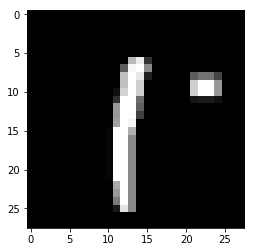

index:  2044 , acq value:  0.687762


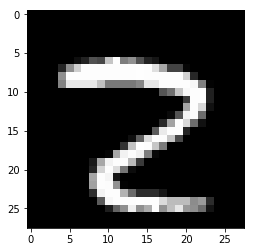

index:  646 , acq value:  0.599156


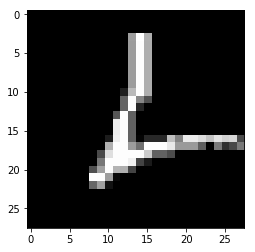

index:  2129 , acq value:  0.565584


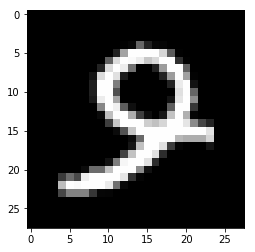

index:  939 , acq value:  0.562957


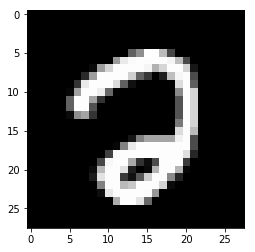

In [10]:
import pylab
%matplotlib inline
for ind in BALD_acq.argsort()[::-1][:5]:  # get the 5 points with highest BALD_acq value
    print('index: ', ind, ', acq value: ', BALD_acq[ind])
    pylab.imshow(x_test[ind].squeeze(), cmap="gray")
    pylab.show()